In [1]:
import numpy as np
from scipy import signal

# Butterworth LP filter

lowpassBW = 2e5  # cutoff frequency
Ts = 1.1925e-07  # sampling time

wc = 2*np.pi*lowpassBW

alfa_w = [1/wc**2,  np.sqrt(2)/wc, 1]
a, b, c = alfa_w

dfilt_a0 =  4*a + 2*Ts*b + Ts**2*c
dfilt_a1 = (-8*a + 2*Ts**2*c) / dfilt_a0
dfilt_a2 = (4*a - 2*Ts*b + Ts**2*c) / dfilt_a0
dfilt_b0 = Ts**2 / dfilt_a0
dfilt_b1 = 2*Ts**2 / dfilt_a0
dfilt_b2 = Ts**2 / dfilt_a0
dfilt_a0 = 1

dfilt_A = np.array([dfilt_a0, dfilt_a1, dfilt_a2])
dfilt_B = np.array([dfilt_b0, dfilt_b1, dfilt_b2])

In [2]:
dfilt_B, dfilt_A

(array([0.00505053, 0.01010106, 0.00505053]),
 array([ 1.        , -1.78914482,  0.80934694]))

In [3]:
# Compare with polynomials from filter generator.
signal.butter(2, lowpassBW, fs=1/Ts)

(array([0.00506849, 0.01013698, 0.00506849]),
 array([ 1.        , -1.78875316,  0.80902713]))

In [4]:
# PID controller

Kp = 1.9678
Ki = 4.6041e+05
Kd = 4.6271e-07
Tf = 2.7131e-07
Nd = 3.6858e+06

pid_a0 = 1
pid_a1 = Nd*Ts - 2
pid_a2 = 1 - Nd*Ts
pid_b0 = Kp+ Kd*Nd
pid_b1 = Kp*(Nd*Ts - 2) + Ki*Ts - Kd*2*Nd
pid_b2 = Kp*(1 - Nd*Ts) + Ki*Ts*(Nd*Ts - 1) + Kd*Nd

pid_A = np.array([pid_a0, pid_a1, pid_a2])
pid_B = np.array([pid_b0, pid_b1, pid_b2])

In [5]:
pid_B, pid_A

(array([ 3.67325652, -6.42669876,  2.77757424]),
 array([ 1.        , -1.56046835,  0.56046835]))

In [6]:
# Read matlab data
from scipy.io import loadmat
mat = loadmat('ilc_test.mat')

ILC_start = mat['ILC_start'][0,0]
ILC_end = mat['ILC_end'][0,0]
time_shift = mat['time_shift'][0,0]
PI_err = mat['PI_err'][:,0]
k_ILC = mat['K_ilc'][0,0]
u_FF = mat['u_FF'][:,0]

In [7]:
# ILC window
start_n = round(ILC_start / Ts)
end_n = round(ILC_end / Ts)

PI_err = PI_err[start_n:end_n + 1]

# PID controller response and time shift
shift_n = round(time_shift / Ts)

PI_err_C = signal.lfilter(pid_B, pid_A, PI_err)
PI_err_C_shift = np.append(PI_err_C[shift_n:], np.zeros(shift_n))

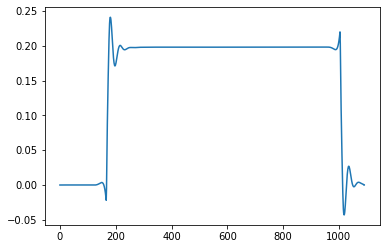

In [8]:
import pylab as pl
pl.plot(PI_err_C_shift)

In [16]:
# FF value from last iteration.
#u_ILC = u_FF[start_n:end_n+1]
u_ILC = np.ones(PI_err_C_shift.size)
    
u_ILC_corr = u_ILC + k_ILC * PI_err_C_shift
u_ILC_new = signal.filtfilt(dfilt_B, dfilt_A, u_ILC_corr)

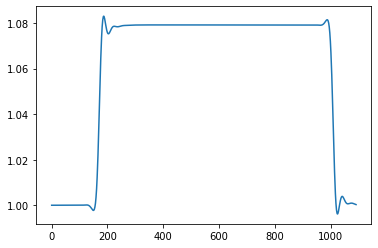

In [17]:
pl.plot(u_ILC_new)

In [18]:
# Initial filter state for direct-form II transposed filter function
z2 = u_ILC_corr[0] * (dfilt_B[2] - dfilt_A[2])
z1 = z2 + u_ILC_corr[0] * (dfilt_B[1] - dfilt_A[1]) 
zi = [z1, z2]

u_ILC_fwd, zf = signal.lfilter(dfilt_B, dfilt_A, u_ILC_corr, zi=zi)
u_ILC_rev, _  = signal.lfilter(dfilt_B, dfilt_A, u_ILC_fwd[::-1], zi=zf)
u_ILC_new = u_ILC_rev[::-1]

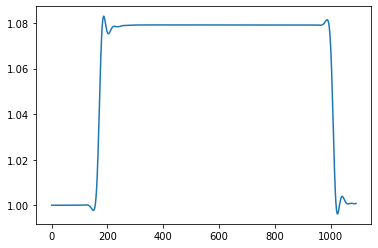

In [19]:
pl.plot(u_ILC_new)

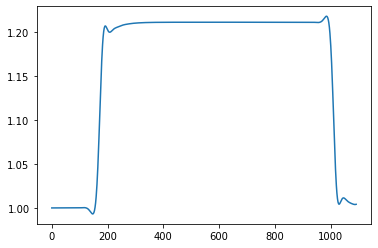

In [20]:
pl.plot(mat['u_ILC_new'])
